# General Overview

-------------


The main goal of this research is to build and compare a few models to predict the housing prices in Ames, Iowa(USA). The data is sourced from Kaggle website: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. It contains housing data - 2919 records in total - where 1460 will be used for training purposes and 1459 for testing our models. There are 4 separate files which we are going to use:

- train.csv -> training data in CSV format
- test.csv -> testing data in CSV format
- data_description.txt -> attributes description

Let's start off by importing the necessary modules and reading the file.

In [1]:
# Basic modules for dataframe manipulation
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine learning
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

# Data Standardization
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

# Validaton
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Don't display warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read files into a dataframe
df_trainset = pd.read_csv('train.csv', low_memory = False)
df_testset = pd.read_csv('test.csv', low_memory = False)

# Save the 'Id' column
train_id = df_trainset['Id']
test_id = df_testset['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_trainset.drop("Id", axis = 1, inplace = True)
df_testset.drop("Id", axis = 1, inplace = True)

# Check the numbers of samples and features
print("Number of records in training set: {}\nNumber of variables in training set: {}\n".format(df_trainset.shape[0], df_trainset.shape[1]))
print("Number of records in testing set: {}\nNumber of variables in testing set: {}".format(df_testset.shape[0], df_testset.shape[1]))

Number of records in training set: 1460
Number of variables in training set: 80

Number of records in testing set: 1459
Number of variables in testing set: 79


It is important to look at the data first in order to understand its format, structure, value types, number(percentage) of missing data, etc. At the beginning we will focus only on the training set and the target variable - SalePrice 

In [3]:
# Change the default number of columns displayed by DataFrame's head method
pd.set_option('display.max_columns', 85)

# Display first 5 rows
df_trainset.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


As we can see, our dataset consists of various data types: integers, floats, strings so let's check further what are they exact types, but before doing so, we will change column headings to lower case.

In [4]:
# Import 'lower_cols' function from helper module which will convert column headings to lower case
from helper import lower_cols

lower_cols(df_trainset)
lower_cols(df_testset)

df_trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-null object
exterior2nd      1460 non-

According to the above result, strings representing categorical variables are stored as objects, which is very unefficient due to the increased size and processing time so we will convert their data type into "category" soon. At this juncture, let's focus on our target variable.

# Target variable
______________________

<a href = "http://ww2.amstat.org/publications/jse/v19n3/Decock/DataDocumentation.txt">Documentation</a> for the Ames Housing Data indicates that there are outliers present in the training data which can be easily detected by plotting the relationship between <i>saleprice</i> and <i>grlivarea</i>. Let's find them now.

#### Checking outliers

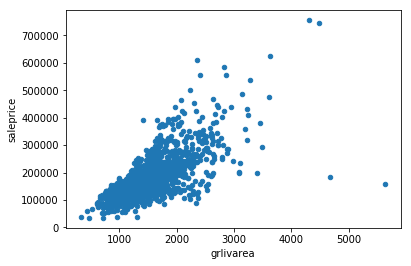

In [5]:
df_trainset.plot('grlivarea', 'saleprice', kind = 'scatter')

At the bottom right we can see two observations with extremely large <i>grlivarea</i> that are of a low price. These values are huge oultliers. Therefore, we can safely delete them.

In [6]:
# Delete outliers
df_trainset = df_trainset.drop(df_trainset[(df_trainset['grlivarea']>4000) & (df_trainset['saleprice']<300000)].index)

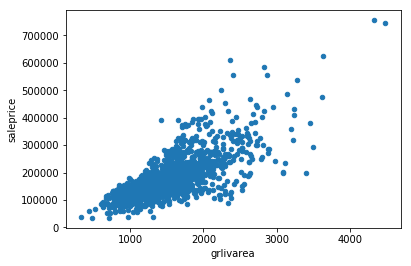

In [7]:
# Check if outliers were removed successfully
df_trainset.plot('grlivarea', 'saleprice', kind = 'scatter')

There are possibly other outliers in both training and testing data but instead of removing them(and losing some information) we will manage to make some of our models robust on them.

#### Examining distribution 

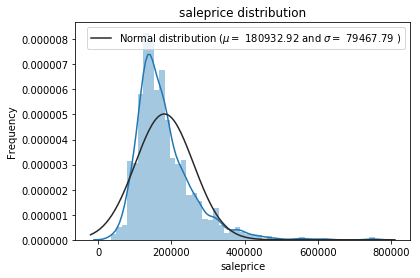

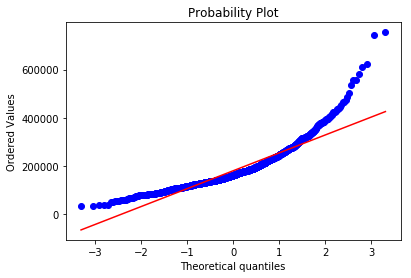

In [8]:
# Import 'plot_distqq' function from helper module to plot the distribution of target variable and normal distribution overlayed + quantile - quantile plot
from helper import plot_distqq
plot_distqq('saleprice', df_trainset)

The target variable is right(positively) skewed. As linear models love normally distributed data , we need to transform this variable and make it more normally distributed.

#### Log-transformation of the target variable

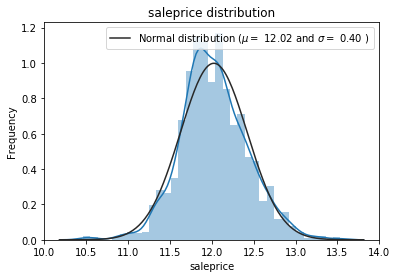

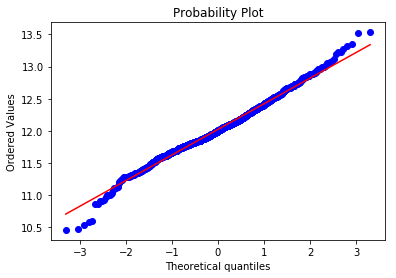

In [9]:
df_trainset["saleprice"] = np.log1p(df_trainset["saleprice"])
plot_distqq('saleprice', df_trainset)

As we can see, applying log transformation to our target variable reduced the skeweness and the data looks more normally distributed.

#### Checking how numerical features are correlated with target variable

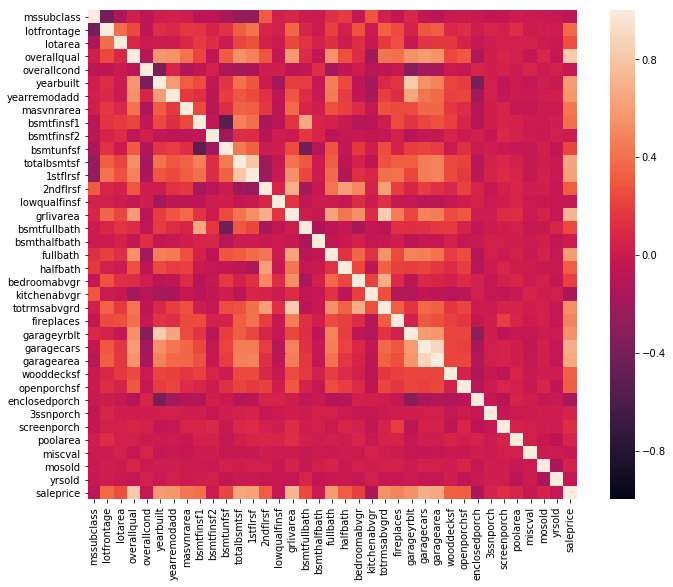

In [10]:
# Calculate correlation map to see how features are correlated with target variable
corrmat = df_trainset.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmin = -1, vmax=1, square=True)

# Data preprocessing


-------------------------------------

Data pre-processing is a critical step that needs to be taken to convert the raw data into a clean data set which is a requirement of the Machine Learning algorithms. The common steps are:

- Cleaning: removal or fixing missing data
- Formatting: adjusting the type of each column and making them suitable for machine learning algorithms
<br></br>

In this section, we are going to convert object data types into category, impute missing values and take a closer look at all variables. Instead of iterating through all variables individually, we will work on certain data types using for loops to ease and speed up the whole process - this will be handled by functions stored in "helper.py" module since converting data and imputing missing values is common in every Data Science - related problem. These actions will result in a clean dataframe object, which then could be used for modelling.

## Cleaning

We have seen above that some variables have missing data which makes them unusable with Machine Learning algorithms. To fix this problem, we will perform imputation using median, mode, None and zeros, but before doing this, let's merge our training and testing datasets and take a closer look at the ratio of null values.

In [11]:
# Assign the dependent variable into a separate variable
target = df_trainset['saleprice']

df_raw = pd.concat([df_trainset.drop('saleprice', axis = 1), df_testset], axis = 0)

In [12]:
# Import 'percent_missing' function from helper module to calculate and display the percentage of missing data
from helper import percent_missing

# Select and print missing values ratio in descending order
missing = percent_missing(df_raw, ascending = False)
missing.head(20)

,Missing Ratio
poolqc,99.691464
miscfeature,96.400411
alley,93.212204
fence,80.425094
fireplacequ,48.680151
lotfrontage,16.660953
garagefinish,5.450806
garageyrblt,5.450806
garagequal,5.450806
garagecond,5.450806


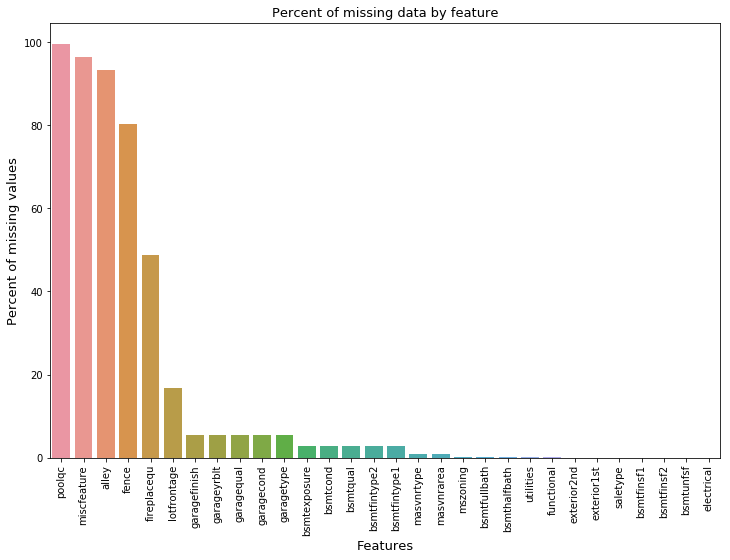

In [13]:
# Import 'plot_bar' function from helper module to plot the distribution of missing data across features
from helper import plot_bar

plot_bar(x = missing.index, y = missing['Missing Ratio'].values, xlabel = 'Features', ylabel = 'Percent of missing values', title = 'Percent of missing data by feature')

In [14]:
# Import helper functions which are used to speed up the preprocessing
from helper import fill_missing_nums, fill_missing_cats

- <b>poolqc</b>: data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general
<br><br>
- <b>miscfeature</b>: data description says NA mean "no misc feature"
<br><br>
- <b>alley</b>: data description says NA means "no alley access"
<br><br>
- <b>fence</b>: data description says NA means "no fence"
<br><br>
- <b>fireplacequ</b>: data description says NA means "no fireplace"
<br><br>
- <b>lotfrontage</b>: since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median <i>lotfrontage</i> of the neighborhood
<br><br>
- <b>garagetype</b>, <b>garagefinish</b>, <b>garagequal</b> and <b>garagecond</b>: replacing missing data with None
<br><br>
- <b>garageyrblt</b>, <b>garagearea</b> and <b>garagecars</b>: replacing missing data with 0 (since no garage = no cars in such garage)
<br><br>
- <b>bsmtfinsf1</b>, <b>bsmtfinsf2</b>, <b>bsmtunfsf</b>, <b>totalbsmtsf</b>, <b>bsmtfullbath</b> and <b>bsmthalfbath</b>: 
    missing values are likely zero for having no basement
<br><br>  
- <b>bsmtqual</b>, <b>bsmtcond</b>, <b>bsmtexposure</b>, <b>bsmtfintype1</b> and <b>bsmtfintype2</b>: For all these categorical basement-related features, NaN means that there is no basement
<br><br>
- <b>masvnrarea</b> and <b>masvnrtype</b>: NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
<br><br>
- <b>mszoning</b>: 'RL' is by far the most common value so we can fill in missing values with mode
<br><br>
- <b>functional</b>: data description says NA means typical
<br><br>
- <b>electrical</b>: it has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
<br><br>
- <b>kitchenqual</b>: only one NA value, and same as electrical, we set 'TA' (which is the most frequent) for the missing value in kitchenqual.
<br><br>
- <b>exterior1st</b> and <b>exterior2nd</b>: again both exterior 1 & 2 have only one missing value. We will just substitute in the most common string
<br><br>
- <b>SaleType</b>: fill in again with most frequent which is "WD"
<br><br>
- <b>mssubclass</b>: NA most likely means "no building class". We can replace missing values with None

In [15]:
none_cols = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
            'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'masvnrtype', 'mssubclass']

zero_cols = ['garageyrblt', 'garagearea', 'garagecars', 'bsmtfinsf1', 'bsmtfinsf2', 'totalbsmtsf', 'bsmtunfsf', 'bsmtfullbath',
            'bsmthalfbath', 'masvnrarea']

In [16]:
for col in none_cols:
    df_raw[col] = df_raw[col].fillna('None')

In [17]:
for col in zero_cols:
    df_raw[col] = df_raw[col].fillna(0)

## Formatting

In [18]:
# Import 'obj_to_cat' function which will convert all object data types into categories
from helper import obj_to_cat

# Convert objects(strings) into category data type
df_raw = obj_to_cat(df_raw)

In [19]:
# Fill missing numerical data with median
df_raw = fill_missing_nums(df_raw)

In [20]:
# Fill missing categorical data with mode
df_raw = fill_missing_cats(df_raw)

df = df_raw.copy()

# Check if the functions worked as intended
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 79 columns):
mssubclass       2917 non-null int64
mszoning         2917 non-null category
lotfrontage      2917 non-null float64
lotarea          2917 non-null int64
street           2917 non-null category
alley            2917 non-null category
lotshape         2917 non-null category
landcontour      2917 non-null category
utilities        2917 non-null category
lotconfig        2917 non-null category
landslope        2917 non-null category
neighborhood     2917 non-null category
condition1       2917 non-null category
condition2       2917 non-null category
bldgtype         2917 non-null category
housestyle       2917 non-null category
overallqual      2917 non-null int64
overallcond      2917 non-null int64
yearbuilt        2917 non-null int64
yearremodadd     2917 non-null int64
roofstyle        2917 non-null category
roofmatl         2917 non-null category
exterior1st      2917 non-null c

#### Displaying exemplary columns

In [21]:
# Import 'display_cols' function from helper module to display columns of desired data type
from helper import display_cols

In [22]:
# Display 10 random rows of variables with category data type
display_cols(df, type = 'category', num_samples = 10)

,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,saletype,salecondition
761,RM,Pave,None,IR1,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,TwnhsE,1Story,Hip,CompShg,CemntBd,CmentBd,Stone,Gd,TA,PConc,Ex,TA,Gd,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Gd,Attchd,Fin,TA,TA,Y,None,None,None,WD,Normal
749,RM,Pave,None,Reg,Lvl,AllPub,CulDSac,Gtl,Blueste,Norm,Norm,Twnhs,2Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,No,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,TA,Detchd,Unf,TA,TA,Y,None,GdPrv,None,WD,Normal
664,RL,Pave,None,IR2,Lvl,AllPub,CulDSac,Gtl,Somerst,RRAn,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Ex,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Ex,Typ,Ex,Attchd,Fin,TA,TA,Y,None,None,None,New,Partial
1349,RM,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,Gable,CompShg,MetalSd,MetalSd,None,TA,Gd,BrkTil,TA,Fa,No,LwQ,Unf,OthW,Fa,N,SBrkr,TA,Typ,None,None,None,None,None,Y,None,None,None,WD,Normal
410,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,Gable,CompShg,BrkComm,Brk Cmn,None,TA,Fa,CBlock,TA,Fa,No,Unf,Unf,GasA,TA,Y,FuseA,TA,Mod,None,Attchd,Unf,TA,TA,Y,None,None,None,COD,Abnorml
1065,RL,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,CemntBd,CmentBd,None,TA,TA,CBlock,Gd,TA,Av,ALQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,Detchd,Unf,TA,TA,Y,None,MnPrv,None,WD,Normal
1129,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,Duplex,SFoyer,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,Gd,TA,Gd,GLQ,Unf,GasA,TA,Y,SBrkr,TA,Typ,None,Detchd,Unf,TA,TA,Y,None,None,None,WD,Normal
145,RM,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,Twnhs,2Story,Gable,CompShg,VinylSd,VinylSd,Stone,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,Gd,Maj1,None,Detchd,Unf,TA,TA,Y,None,None,None,WD,Normal
697,RL,Pave,None,IR2,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1048,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


One thing that should bring our attention here:

- We can delete 'utilities' variable from our dataset as it takes in "AllPub' value for nearly every observation, hence it will not help our models to make better decisions

In [23]:
# Delete 'utilities' column 
df.drop(['utilities'], axis = 1, inplace = True)

In [24]:
# Display 10 random rows of variables with float data type
display_cols(df, type = 'float', num_samples = 10)

,lotfrontage,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,bsmtfullbath,bsmthalfbath,garageyrblt,garagecars,garagearea
659,75.0,0.0,637.0,0.0,849.0,1486.0,1.0,0.0,1968.0,2.0,480.0
1246,68.0,0.0,181.0,0.0,744.0,925.0,1.0,0.0,1990.0,2.0,484.0
1388,70.0,0.0,0.0,0.0,872.0,872.0,0.0,0.0,2002.0,2.0,529.0
456,75.0,0.0,445.0,250.0,412.0,1107.0,0.0,0.0,2000.0,3.0,642.0
1128,82.0,0.0,924.0,0.0,46.0,970.0,1.0,0.0,1974.0,2.0,528.0
339,80.0,0.0,433.0,95.0,0.0,528.0,1.0,0.0,1959.0,1.0,288.0
1025,81.0,0.0,386.0,522.0,332.0,1240.0,1.0,0.0,1956.0,1.0,323.0
258,80.0,172.0,361.0,0.0,602.0,963.0,0.0,0.0,2001.0,2.0,564.0
839,110.0,280.0,938.0,0.0,379.0,1317.0,1.0,0.0,2003.0,3.0,818.0
969,75.0,105.0,513.0,0.0,75.0,588.0,1.0,0.0,1958.0,1.0,264.0


In [25]:
# Display 10 random rows of variables with int64 data type
display_cols(df, type = 'int64', num_samples = 10)

,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
1021,20,7406,7,5,2006,2006,1220,0,0,1220,2,0,2,1,6,0,105,54,0,0,0,0,0,7,2006
636,50,5914,5,9,1890,1996,684,396,0,1080,1,0,3,1,5,0,0,165,30,0,0,0,0,9,2008
20,60,14215,8,5,2005,2006,1158,1218,0,2376,3,1,4,1,9,1,240,154,0,0,0,0,0,11,2006
986,70,10337,8,9,1910,1999,909,863,0,1772,2,1,3,1,7,0,0,0,0,0,0,0,0,5,2007
887,60,8640,8,5,2007,2007,896,896,0,1792,2,1,3,1,8,0,184,96,0,0,0,0,0,11,2007
923,120,8012,6,5,1993,1994,1617,0,0,1617,2,0,2,1,5,1,0,69,0,0,0,0,0,7,2008
333,120,8198,7,5,2004,2004,1358,0,0,1358,2,0,2,1,6,1,192,30,0,0,0,0,0,7,2008
65,60,9591,8,5,2004,2005,1143,1330,0,2473,2,1,4,1,9,1,192,151,0,0,0,0,0,10,2007
1247,80,12328,6,5,1976,1976,1034,0,0,1034,1,0,3,1,6,0,0,0,0,0,0,0,0,5,2010
54,80,7134,5,5,1955,1955,1360,0,0,1360,1,0,3,1,6,1,0,50,0,0,0,0,0,2,2007


#### Displaying basic statistics of numerical features

In [26]:
# Import 'display_nums_stats' function from helper module to display the basic statistics of numerical columns
from helper import display_nums_stats

display_nums_stats(df)

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,57.135756,68.983888,10139.439150,6.086390,5.564964,1971.287967,1984.248200,100.931436,438.864930,49.599246,560.50360,1048.967775,1157.692492,335.861502,4.697635,1498.251628,0.428865,0.061364,1.567364,0.379842,2.860130,1.044566,6.448063,0.596160,1870.270141,1.765513,472.247515,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938
std,42.532140,20.810549,7807.036512,1.406704,1.113414,30.286991,20.892257,178.032499,444.180542,169.232130,439.69883,429.472008,385.264298,428.119663,46.412570,496.908626,0.523943,0.245687,0.552465,0.502782,0.822967,0.214532,1.564281,0.644773,449.826161,0.762102,214.762268,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.00000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,60.000000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.00000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.00000,988.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,78.000000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,733.000000,0.000000,804.00000,1302.000000,1384.000000,704.000000,0.000000,1743.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4010.000000,1526.000000,2336.00000,5095.000000,5095.000000,2065.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


#### Converting some of the nominal numerical variables into categories

In [27]:
# Import 'nominalnums_to_cat' function from helper module
from helper import nominalnums_to_cat

# Convert nominal numerical variables(having less than 30 unique values) into categories and return names of these which have more than 8 unique values for further check
cats_to_verify = nominalnums_to_cat(df, unique_values_split = 30, boundary = 8)

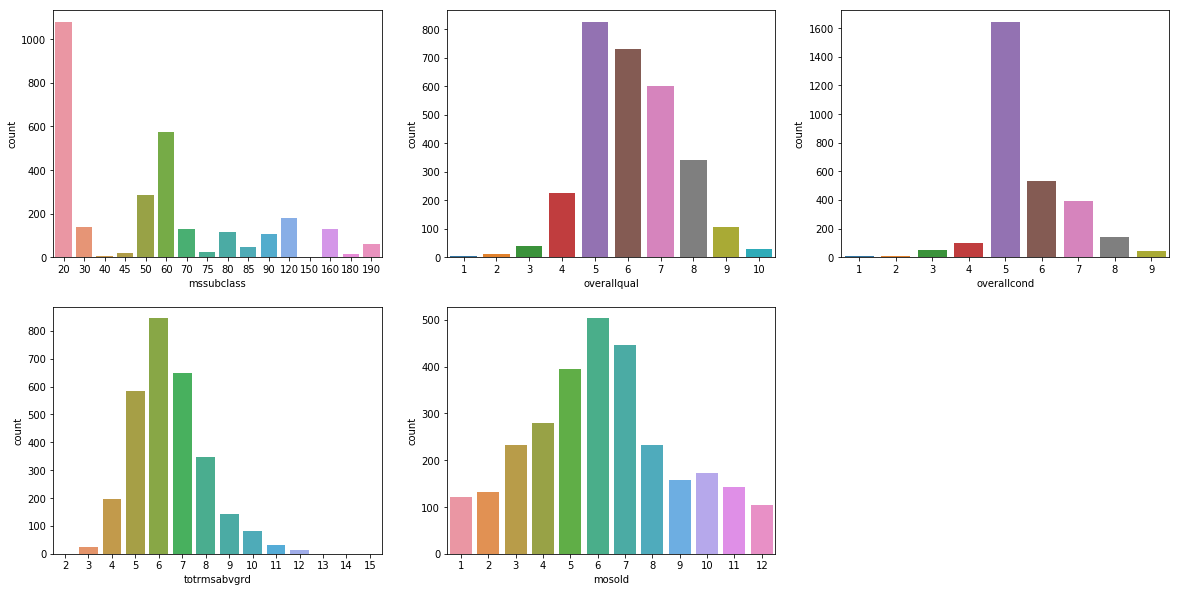

In [28]:
# Import 'display_plots' function from helper module
from helper import display_plots

# Display count plots for columns returned by 'nominalnums_to_cat' function to verify their values 
display_plots(df, cats_to_verify, kind = 'count')

In the above charts we can see that most of the houses have 4 to 9 rooms and overall quality and condition scores between 5 to 8. Also, it's worth pointing out that most of the houses were sold between March and August. This should not be surprising, as it is much easier to relocate when the weather conditions are more favorable. According to the 'mssubclass' attribute, most of the houses are 1 and 2-story buildings built in 1946 or later. 

# Feature Engineering
_____________

#### Creating new features

In this section we are going to create new features representing mean house price by neighboorhood and total number of square feets. Since sale price is known only for the training subset, we will use it to calculate the mean price for neighborhood. 

In [29]:
subjectives = ['neighborhood']

# Calculate and add mean price by neighbourhood
for col in subjectives:
    col_mean = dict(df_trainset.groupby(col)['saleprice'].mean())
    df['logmean_prc_by_'+col[:4]] = df[col].map(col_mean)
    
# Add total square footage feature 
df['totalsf'] = df['totalbsmtsf'] + df['1stflrsf'] + df['2ndflrsf']

In [30]:
df.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,logmean_prc_by_neig,totalsf
0,60,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,12.163647,2566.0
1,20,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,12.344180,2524.0
2,60,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,12.163647,2706.0
3,70,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,12.206664,2473.0
4,60,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,12.676003,3343.0


In [31]:
df.info(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 80 columns):
mssubclass             2917 non-null category
mszoning               2917 non-null category
lotfrontage            2917 non-null float64
lotarea                2917 non-null int64
street                 2917 non-null category
alley                  2917 non-null category
lotshape               2917 non-null category
landcontour            2917 non-null category
lotconfig              2917 non-null category
landslope              2917 non-null category
neighborhood           2917 non-null category
condition1             2917 non-null category
condition2             2917 non-null category
bldgtype               2917 non-null category
housestyle             2917 non-null category
overallqual            2917 non-null category
overallcond            2917 non-null category
yearbuilt              2917 non-null int64
yearremodadd           2917 non-null int64
roofstyle              2917 n

Now we are left with 56 categorical and 24 numerical variables. Since in this notebook we are going to use advanced regression techniques: Lasso, ElasticNet, Kernel Ridge, Random Forest, Gradient Boosted Trees, XGBoost and Light GBM Regressors we will have to standarize the values of numerical variables as some of these Machine Learning algorithms are prone to the differences in measurement scales. Also, they will help us to find the most important explanatory variables. Before modelling let's calculate the skeweness of numerical features(eventually deal with it), convert values of ordered categorical features into numbers and create dummy variables from the remaining categorical variables.

#### Measuring skeweness

In [32]:
# Import 'calculate_skeweness' function from helper module which will calculate skeweness across numerical columns and return a dataframe
from helper import calculate_skewness

skewness = calculate_skewness(df)
skewness.head(10)

,Skewness
miscval,21.939672
poolarea,17.688664
lotarea,13.109495
lowqualfinsf,12.084539
3ssnporch,11.372080
bsmtfinsf2,4.144503
enclosedporch,4.002344
screenporch,3.945101
masvnrarea,2.621719
openporchsf,2.529358


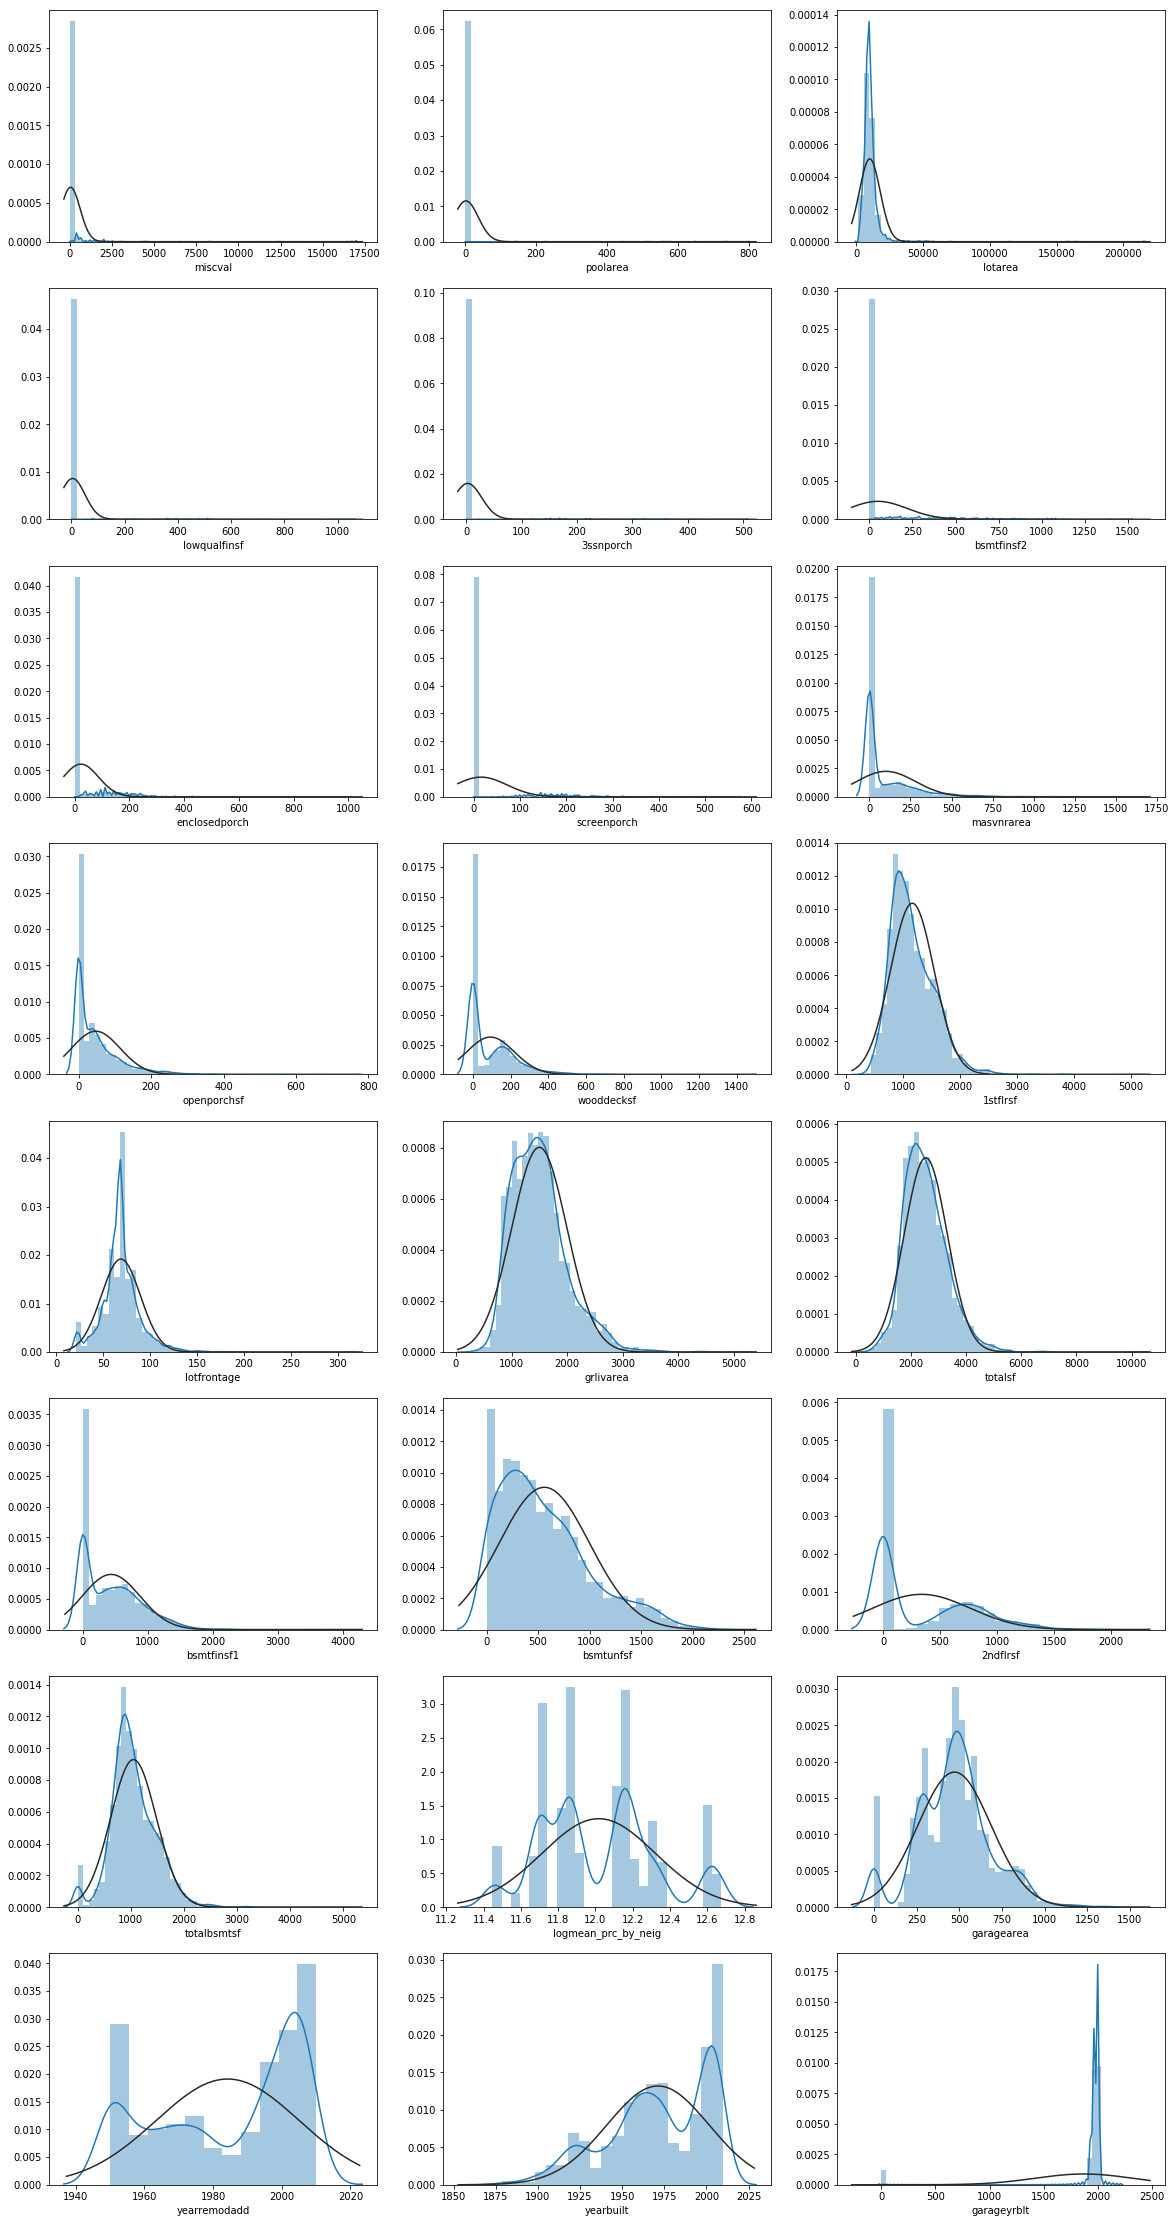

In [33]:
# Display distribution plots of skewed features
display_plots(df, skewness[abs(skewness) > 0.75].index, kind = 'dist')


In [34]:
# Import 'box_cox_transform' function from helper module to apply transformation to highly skewed features
from helper import box_cox_transform

box_cox_transform(df, skewness, lamb = 0.15)

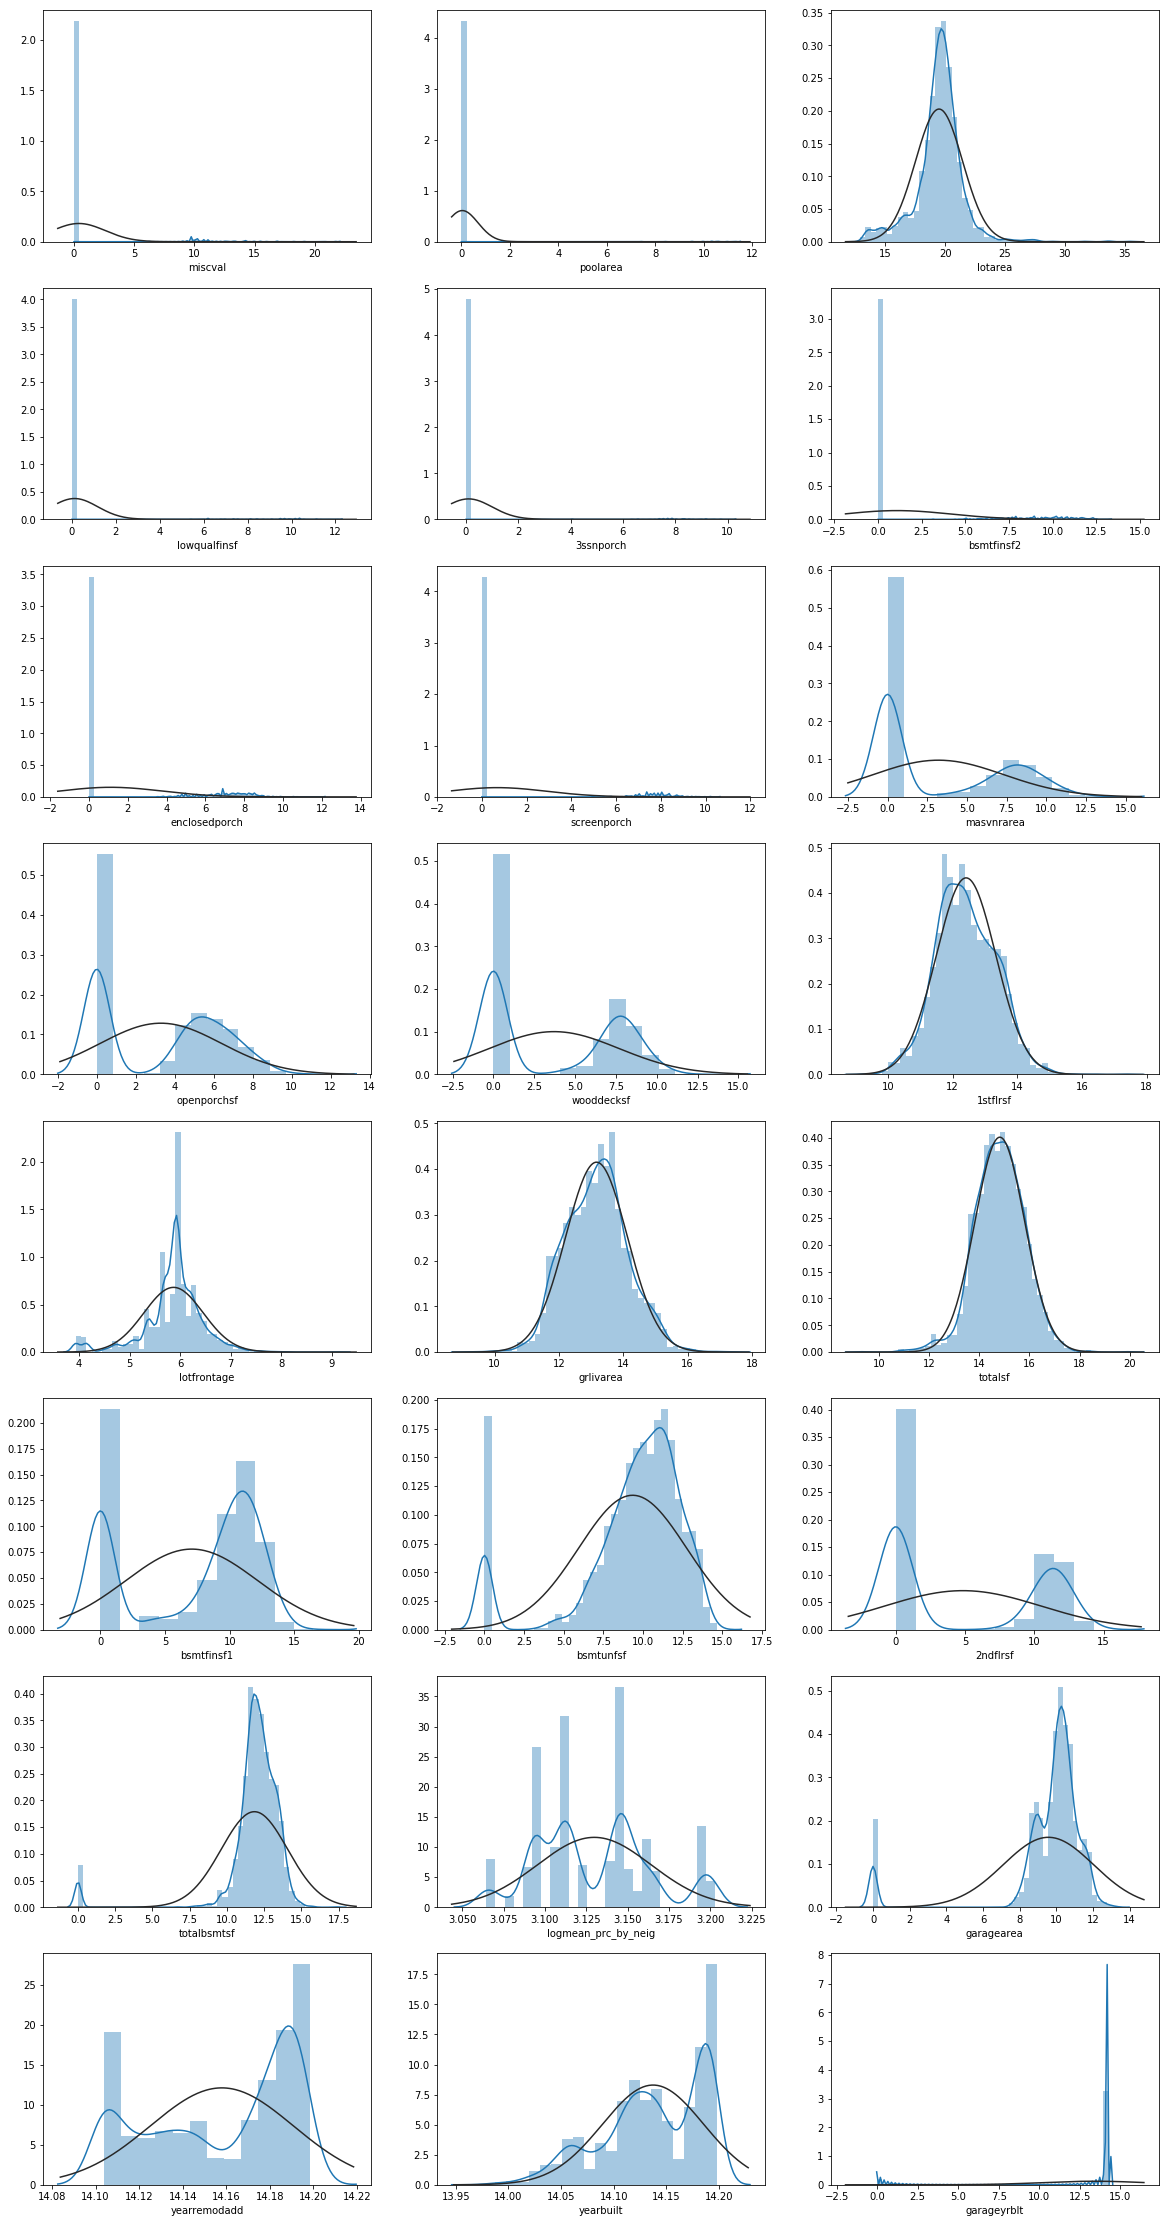

In [35]:
# Display distribution plots of skewed features
display_plots(df, skewness[abs(skewness) > 0.75].index, kind = 'dist')

#### Label Encoding some categorical variables that may contain information in their ordering set

In [36]:
cols = ('fireplacequ', 'bsmtqual', 'bsmtcond', 'garagequal', 'garagecond', 
        'exterqual', 'extercond','heatingqc', 'poolqc', 'kitchenqual', 'bsmtfintype1', 
        'bsmtfintype2', 'functional', 'fence', 'bsmtexposure', 'garagefinish', 'landslope',
        'lotshape', 'paveddrive', 'street', 'alley', 'centralair', 'mssubclass', 'overallcond', 
        'yrsold', 'mosold')

# Apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(df[c].values)) 
    df[c] = lbl.transform(list(df[c].values))

#### Getting dummy categorical features

In [37]:
# Apply One-Hot encoding
df = pd.get_dummies(df)

In [38]:
# Display dataframe's shape
df.shape

(2917, 273)

#### Dividing the dataset into training, validation and testing subsets

In [39]:
# We excluded the target variable - SalePrice - at the very beginning so now we only have to divide our dataframe into training and testing sets
trn_last_idx = 1458

# Split dataframe into training and testing subsets
df_train = df[:trn_last_idx]
df_test = df[trn_last_idx:]

# Modelling

_____________

## Metrics

It is crucial for every Machine Learing project to select an appropriate metric used for validating the predictions. In this competition all submissions are evaluated on Root-Mean-Squared-Error (RMSE) between log of predicted value and log of the real transaction value. Taking logs means that we are measuring results using RMSLE and that errors in predicting expensive houses and cheap houses will affect the result equally.

## Machine Learning

We are well prepared now for an endeavour to create a robust and accurate predictive models.

### Base models

#### Lasso Regression

LASSO - (Least Absolute Shrinkage and Selection Operator) is a regression method that involves penalizing the absolute size of the regression coefficients.

By penalizing (or equivalently constraining the sum of the absolute values of the estimates) you end up in a situation where some of the parameter estimates may be exactly zero. The larger the penalty applied, the further estimates are shrunk towards zero.

This is convenient when we want some automatic feature/variable selection, or when dealing with highly correlated predictors, where standard regression will usually have regression coefficients that are 'too large'.

This model may be very sensitive to outliers so we need to make it more robust on them. For that we are going to use the sklearn's <b>Robust Scaler</b> in pipeline.

In [40]:
# Import print_score function from helper module to assess the performance of our models
from helper import print_score

# Instantiate pipeline object with RobustScaler and Lasso Regressor
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005))

# Evaluate model's performance
%time print_score(lasso, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1113  |  Standard Deviation of RMSE: 0.0062  |  Training R^2: 0.937
Wall time: 4.53 s


##### Discovering most important features chosen by Lasso-based model

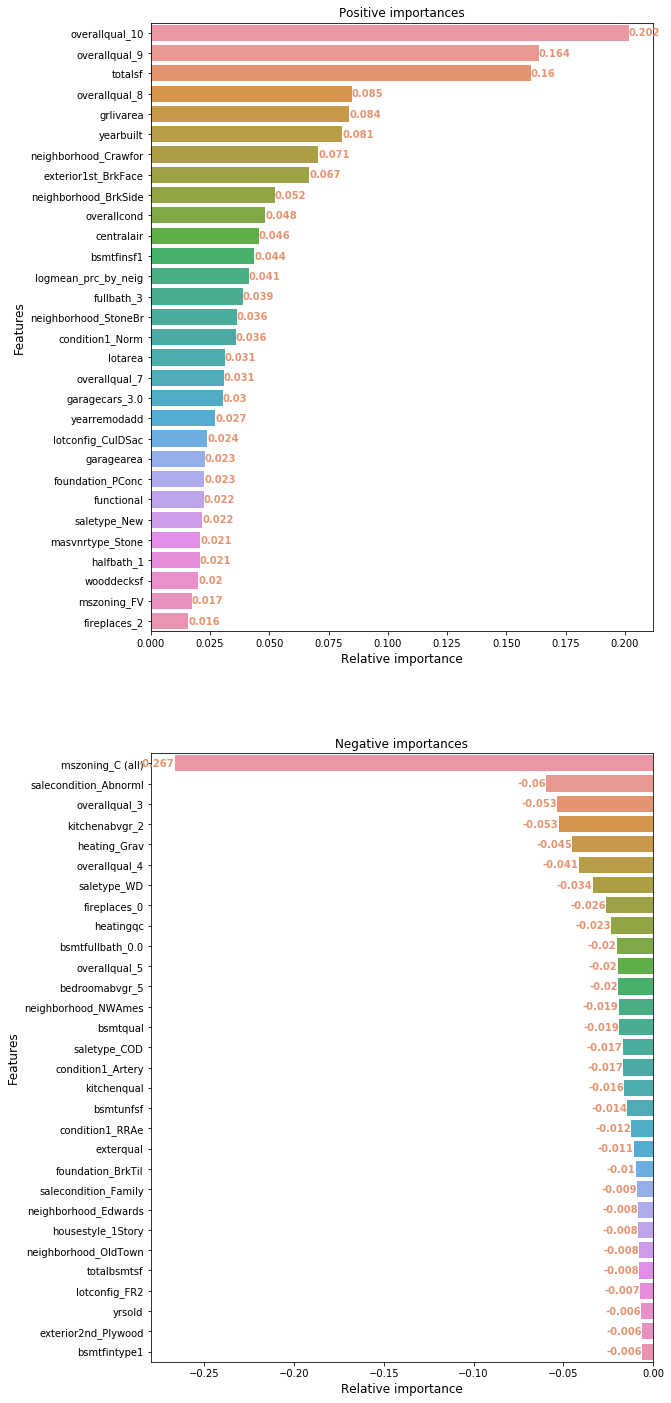

In [41]:
# Import reg_importances function from helper module which will return/plot most important features found by regression model
from helper import reg_importances

positives_lasso, negatives_lasso = reg_importances(lasso, df_train, boundary = 30,  plot = True, step_name='lasso')

#### Elastic Net Regression

Elastic net regression combines L1 (LASSO) and L2 (Ridge Regression) normalizations into a penalized model for generalized linear regression. This gives it sparsity (L1) and robustness (L2) properties. Since this algorithm is also prone to outliers, we need to get rid of them using RobustScaler.

In [42]:
# Instantiate pipeline object with RobustScaler and Elastic Net Regressor 
enet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9))

# Evaluate model's performance
%time print_score(enet, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1113  |  Standard Deviation of RMSE: 0.0064  |  Training R^2: 0.938
Wall time: 3.93 s


##### Discovering most important features chosen by Elastic Net-based model

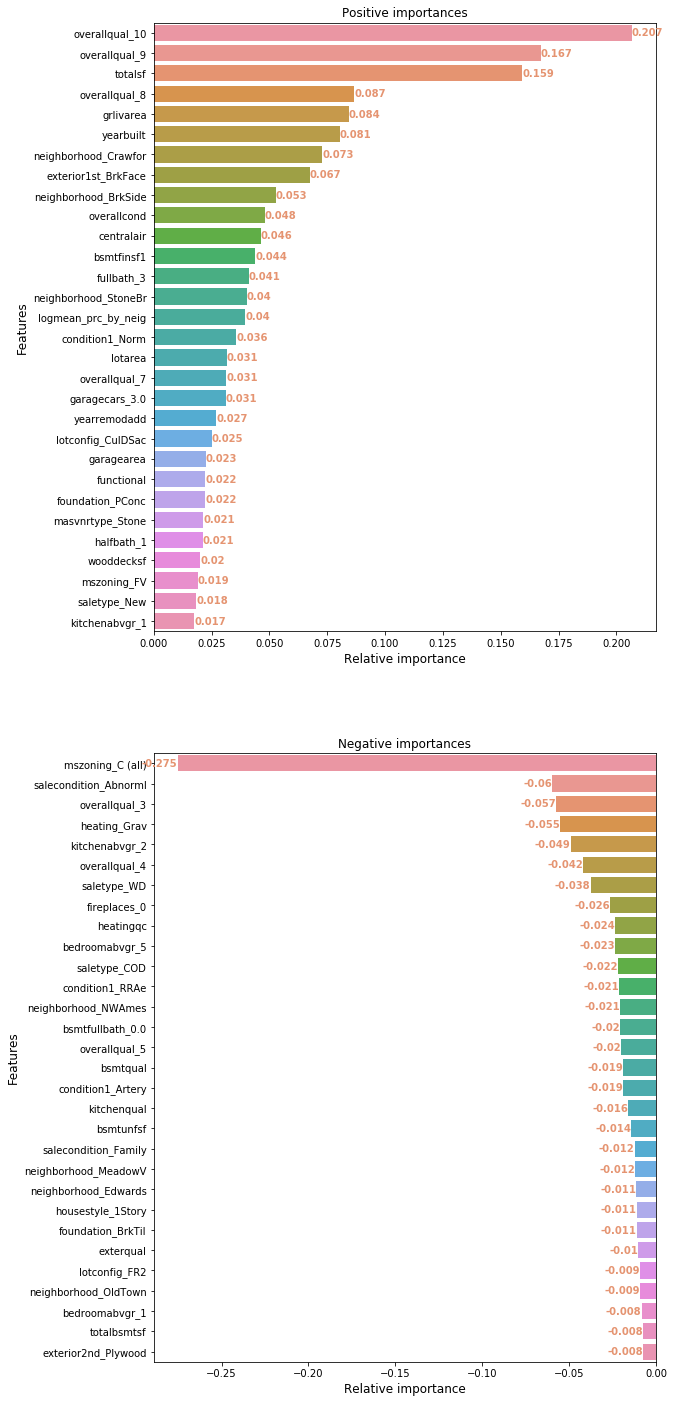

In [43]:
# Import reg_importances function from helper module which will return/plot most important features found by regression model
from helper import reg_importances

positives_enet, negatives_enet = reg_importances(enet, df_train, boundary = 30,  plot = True, step_name='elasticnet')

Just by looking at the above plots, we can assume that the most important features will vary across different algorithms, but these having the biggest predictive power will likely be chosen as most important by most of them.

#### Kernel Ridge Regression 

According to “Machine Learning: A Probabilistic Perspective” Murphy, K. P. - chapter 14.4.3, pp. 492-493, The MIT Press, 2012 Kernel Ridge Regression (KRR) combines Ridge Regression (linear least squares with l2-norm regularization) with the kernel trick. It thus learns a linear function in the space induced by the respective kernel and the data. For non-linear kernels, this corresponds to a non-linear function in the original space. Since this algorithm is resilient to possible outliers we don't need to tackle them with RobustScaler object.

In [44]:
# Instantiate Kernel Ridge Regressor
krr = KernelRidge(alpha = 1, kernel = 'polynomial', degree = 2, coef0 = 8.5)

# Evaluate model's performance
%time print_score(krr, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1160  |  Standard Deviation of RMSE: 0.0071  |  Training R^2: 0.957
Wall time: 4.21 s


#### Random Forests

It is a sort of universal Machine Learning technique, a way of predicting something that could be of any kind - category or continuous variable (like in this competition - price). In general, it does not overfit too badly and it is not hard to stop it from overfitting. It has few (if any) statistical assumptions. It does not assume that given data is normally distributed, standarized, relationships are linear, or that interactions have been specified. It requires relatively few feature engineering, like for example taking 'log' or 'exp' of the data.

Random Forest algorithm is based on bagging trees. The idea of bagging is to create a couple of subsets of data and use them to train the model. For example imagine as if we created five different models, each of which was only somewhat predictive, but the models were not correlated with each other. Five models would have a different insight into the relationships of the data. If we took average of them, we end up with the ensemble of different models. The number of said models can be set using n_estimators hyperparameter.

Random Forest is not so easy to explain due to higher complexity. However, there are some tools making it possible like the 'plot_feat_imp' function from the helper module which can be harnessed to point out the most important features that influence the performance of our model.

In [45]:
# Instantiate Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators = 3000, max_features = 'sqrt',
                                     min_samples_leaf = 1, n_jobs = -1,
                                     random_state = 12)

# Evaluate model's performance
%time print_score(rf_regressor, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1395  |  Standard Deviation of RMSE: 0.0085  |  Training R^2: 0.984
Wall time: 24 s


#### Gradient Boosted Regressor

In [46]:
# Instantiate Gradient Boosted Regressor
gb_regressor = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.03,
                                   max_depth = 2, max_features = 'sqrt',
                                   min_samples_leaf = 11, min_samples_split = 14, 
                                   loss = 'huber', random_state = 12)

# Evaluate model's performance
%time print_score(gb_regressor, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1143  |  Standard Deviation of RMSE: 0.0054  |  Training R^2: 0.958
Wall time: 12.9 s


#### XGBoost Regressor

XGBoost is sometimes named as 'an ultimate weapon of a data scientist'. It is a powerful algorithm, which very often rises to heights of any predictive model. A vast majority of data competitions are won by XGB experts. It is a versatile and sophisticated technique, which is relatively fast (given its complexity) and produces outstanding results.

In [47]:
# Instantiate XGBoost Regressor
xgb_regressor = xgb.XGBRegressor(colsample_bytree = 0.6, gamma = 0.04, 
                             learning_rate = 0.05, max_depth = 3, 
                             min_child_weight = 2, n_estimators = 3000,
                             reg_alpha = 0.45, reg_lambda = 0.55,
                             subsample = 0.49, silent = 1,
                             random_state = 12, n_jobs = -1)

# Evaluate model's performance
%time print_score(xgb_regressor, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1176  |  Standard Deviation of RMSE: 0.0079  |  Training R^2: 0.967
Wall time: 37.5 s


#### LightGBM

A fast, distributed, high performance gradient boosting (GBDT, GBRT, GBM or MART) framework based on decision tree algorithms, used for ranking, classification and many other machine learning tasks. It is under the umbrella of the DMTK(http://github.com/microsoft/dmtk) project of Microsoft.

In [48]:
# Instantiate Light GBM Regressor
lgbm_regressor = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                              learning_rate = 0.06, n_estimators = 700,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.08,
                              feature_fraction_seed = 8, bagging_seed = 9,
                              min_data_in_leaf = 7, min_sum_hessian_in_leaf = 4)

# Evaluate model's performance
%time print_score(lgbm_regressor, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1142  |  Standard Deviation of RMSE: 0.0079  |  Training R^2: 0.967
Wall time: 8.62 s


As we can notice, results achieved by different regression algorithms vary significantly and there are big discrepancies between their execution time. Best results so far were achieved by Lasso and Elastic Net Regressors both when it comes to the RMSE and execution time. 

### Stacking models

#### Simplest stacking approach : averaging base models

This simple approach of averaging base models may help us to improve our predictive performance. We will begin by building a new class to extend scikit-learn with our model and leverage encapsulation and code reuse (inheritance). In this section we are going to leverage 6 out of 7 previously instantiated models to get the average prediction of sale price for each house.

In [49]:
# Import and instantiate AveragedScorer object from helper module which will average the predictions made by each passed model
from helper import AveragedScorer

averaged_models = AveragedScorer(models = [lasso, enet, krr, lgbm_regressor, gb_regressor])

# Evaluate model's performance
%time print_score(averaged_models, df_train, target, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1085  |  Standard Deviation of RMSE: 0.0063  |  Training R^2: 0.956
Wall time: 39.6 s


In [50]:
averaged_models.fit(df_train, target)
averaged_pred = np.expm1(averaged_models.predict(df_test))

In [51]:
avmods = pd.DataFrame([test_id, averaged_pred],).T
avmods.columns = ['Id','SalePrice']
avmods['Id'] = avmods['Id'].astype(int)
avmods.to_csv('submissions/avmods.csv', index = False)

#### Advanced stacking approach using base models

In this approach, we are going to create a meta-model using previously averaged base models and use the out-of-folds predictions of the base models to train it.

The procedure for the training part, may be described as follows:

1. Split the total training set into two separate sets (train and validation)

2. Train several base models on the first part (train)

3. Test base models on the second part (validation)

After the above steps we are going to use the predictions made on validation set (called out-of-folds predictions) as the inputs and real values (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively. If we take for example a 5-fold stacking, we begin by splitting the training data into 5 folds. Then we will do 5 iterations where in each iteration, we train every base model on 4 folds and predict on the remaining - validation - fold.

After all iterations and making sure that the entire data was used to get out-of-folds predictions, we will use them as a new feature to train our meta-model.

For the prediction part, we will average predictions made by all base models on the test data and use them as meta-features on which the final prediction will be made with the meta-model.

<img src="imgs/metamodel.jpg">

Image taken from <a href = "https://www.kaggle.com/getting-started/18153#post103381">Faron</a>

<img src = "imgs/kazanowa.gif">

Gif taken from <a href="http://blog.kaggle.com/2017/06/15/stacking-made-easy-an-introduction-to-stacknet-by-competitions-grandmaster-marios-michailidis-kazanova/">KazAnova's interview</a>

In the gif, the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is A+B because we know the values of target variable for them which allows us to split them into training part(A) and validation part(B). In this case, part C is used as a test set.

B1 is the prediction from the validation part and it serves as the new feature used to train the meta-model 3 while C1 which is the prediction from the test dataset is the meta-feature on which the final prediction is done.

To make the two approaches comparable (by using the same number of models), let's average Elastic Net, Kernel Ridge Regressor, Gradient Boosted Regressor, LightGBM Regressor and use Lasso as a meta-model.

In [52]:
# Import StackedAveragedScore object from helper module
from helper import StackedAveragedScorer


# Save training and testing data as numpy arrays to prevent 'ValueError: Input contains NaN, infinity or a value too large for dtype('float64')' from occurring
df_train_mat = df_train.as_matrix().astype(np.float)
target_mat = target.as_matrix().astype(np.float)
df_test_mat = df_test.as_matrix().astype(np.float)


# Instantiate StackedAveragedScorer object
stacked_averaged_models = StackedAveragedScorer(base_models = [enet, krr, lgbm_regressor, xgb_regressor, gb_regressor],
                                                 meta_model = lasso)

%time print_score(stacked_averaged_models, df_train_mat, target_mat, scoring_func = 'rmsle_cv', n_folds = 5)

Average cross-validated RMSE: 0.1086  |  Standard Deviation of RMSE: 0.0059  |  Training R^2: 0.953
Wall time: 4min 12s


This time we achieve even better score by adding a meta learner so let's predict values on the testing set and create our final submission file.

In [53]:
stacked_averaged_models.fit(df_train_mat, target_mat)
stacked_pred = np.expm1(stacked_averaged_models.predict(df_test_mat))

In [54]:
stavmods = pd.DataFrame([test_id, stacked_pred],).T
stavmods.columns = ['Id','SalePrice']
stavmods['Id'] = stavmods['Id'].astype(int)
stavmods.to_csv('submissions/stavmods2.csv', index = False)

TO BE CONTINUED...